In [2]:
import jupyter_black

import sys, os
import numpy as np
import matplotlib.pyplot as plt

jupyter_black.load()


if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [3]:
# Import torch modules

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid, save_image

import lightning.pytorch as pl

In [4]:
# Import custom modules

import helper_plots as hplt
import data.dataset, data.transform

# from model.vae import Encoder, Decoder
from helper_train import train

## Settings

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 111
LEARNING_RATE = 0.0005
NUM_EPOCHS = 200
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 1
LATENT_SIZE = 4
RECONSTRUCTION_TERM_WEIGHT = 1

## Dataset

In [6]:
# Directory with source data

cells_dir = "/usr/src/data/separated_bacterias"
samples_dir = "/usr/src/samples"

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        data.transform.CellPadResize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = data.dataset.CellsImageDataset(cells_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Chech dataset and trainloader

print(f"Len of dataset:  {len(dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  1910 images
Len of trainloader:  15 batches
Shape of batch:  torch.Size([128, 1, 64, 64])


In [8]:
class Trim(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.size = image_size

    def forward(self, x):
        return x[:, :, : self.size, : self.size]


class Encoder(nn.Module):
    def __init__(self, image_size, latent_size):
        super().__init__()
        self.image_size = image_size
        self.latent_size = latent_size

        self.convolution_seria = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
            nn.Flatten(),  # (N, 64, 8, 8) -> (N, 4096)
        )

        self.z_mean = torch.nn.Linear(4096, self.latent_size)
        self.z_log_var = torch.nn.Linear(4096, self.latent_size)

    def forward(self, x):
        x = self.convolution_seria(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        eps = torch.randn((z_mean.size(0), self.latent_size)).to(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        z = z_mean + eps * torch.exp(z_log_var / 2.0)
        return z, z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self, image_size, latent_size):
        super().__init__()
        self.image_size = image_size
        self.latent_size = latent_size

        self.convolution_transpose_seria = nn.Sequential(
            torch.nn.Linear(self.latent_size, 4096),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=0),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
            Trim(self.image_size),  # 1x65x65 -> 1x64x64
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.convolution_transpose_seria(x)

In [9]:
class VariationalAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder, learning_rate=0.001):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_size = encoder.latent_size
        self.lr = learning_rate

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x = batch

        z, z_mean, z_log_var = self.encoder(x)
        x_hat = self.decoder(z)

        pixelwise = torch.nn.functional.mse_loss(x_hat, x, reduction="none")
        pixelwise = pixelwise.view(batch.size(0), -1).sum(dim=1)
        pixelwise = pixelwise.mean()

        kl_div = -0.5 * torch.sum(
            1 + z_log_var - z_mean**2 - torch.exp(z_log_var), axis=1
        )  # sum over latent dimension  # type: ignore
        kl_div = kl_div.mean()  # average over batch dimension

        loss = pixelwise + kl_div

        # Logging to TensorBoard by default
        self.log("train_combined_loss", loss)
        self.log("pixelwise_loss", pixelwise)
        self.log("kl_div", kl_div)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [10]:
encoder = Encoder(IMAGE_SIZE, LATENT_SIZE)
decoder = Decoder(IMAGE_SIZE, LATENT_SIZE)

vae = VariationalAutoEncoder(encoder, decoder, LEARNING_RATE)

In [11]:
trainer = pl.Trainer(max_epochs=100, log_every_n_steps=4)
trainer.fit(vae, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | encoder | Enc

Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [12]:
def show_grid_samples(model, n_images: int, file_name="", save_dir=os.getcwd()):
    latent_size = model.latent_size
    with torch.no_grad():
        rand_features = torch.randn(n_images, latent_size)
        generated_images = model.decoder(rand_features)

    grid = make_grid(generated_images, nrow=int(np.sqrt(n_images)), pad_value=1)
    grid = transforms.ToPILImage()(grid)
    grid.show()

    if file_name:
        path = f"{save_dir}/{file_name}.png"
        grid.save(path)

    return generated_images


def generate_and_save_samples(samples_dir, n_samples, batch_size, model, image_size):
    latent_size = model.latent_size

    last_batch = n_samples % batch_size
    count = n_samples // batch_size if last_batch == 0 else n_samples // batch_size + 1
    idx = 0

    for step in range(count):
        with torch.no_grad():
            if step == count - 1 and last_batch != 0:
                rand_features = torch.randn(last_batch, latent_size)
            else:
                rand_features = torch.randn(batch_size, latent_size)
            samples = model.decoder(rand_features)

        for sample in samples:
            save_image(sample, f"{samples_dir}/sample_{idx}.png")
            idx += 1

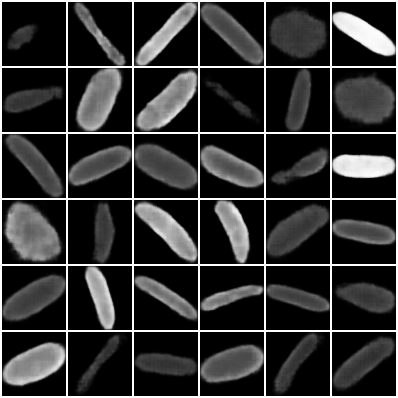

In [39]:
# Create grid of generated samples and show it

samples = show_grid_samples(vae, 36, "grid_cells_vae")

In [40]:
generate_and_save_samples(samples_dir, 20, 20, vae, IMAGE_SIZE)

In [13]:
from torchmetrics.image.fid import FrechetInceptionDistance
import time


def count_fid_metric(
    dataloader: DataLoader,
    model,
    image_size: int,
    latent_size: int,
    channels: int,
    min_n_samples=1000,
    n_feature=2048,
    normalize=False,
):
    """Compute the FID metric for evaluation of the diffusion models"""

    batch_size = next(iter(dataloader)).shape[0]
    count = int(np.ceil(min_n_samples / batch_size))

    real_imgs, fake_imgs = [], []

    start = time.time()
    for i in range(count):
        images = next(iter(dataloader))
        real_imgs.append(images)

        with torch.no_grad():
            rand_features = torch.randn(batch_size, latent_size)
            samples = model.decoder(rand_features)
            fake_imgs.append(samples)
    stop = time.time()

    real_imgs = torch.cat(real_imgs)
    real_imgs = real_imgs if normalize else (real_imgs * 255).to(torch.uint8)

    fake_imgs = np.concatenate(fake_imgs)
    fake_imgs = torch.tensor(fake_imgs)
    fake_imgs = fake_imgs if normalize else (fake_imgs * 255).to(torch.uint8)
    print(f"{fake_imgs.shape[0]} samples are generated, time = {stop - start :.3f} sec")

    if channels != 3:
        real_imgs = real_imgs.repeat(1, 3, 1, 1)
        fake_imgs = fake_imgs.repeat(1, 3, 1, 1)

    fid = FrechetInceptionDistance(feature=n_feature, normalize=normalize)
    start = time.time()
    fid.update(real_imgs, real=True)
    fid.update(fake_imgs, real=False)
    metric = fid.compute()
    stop = time.time()
    print(f"FID is computed, time = {stop - start :.3f} sec")

    return metric

In [14]:
count_fid_metric(train_loader, vae, IMAGE_SIZE, LATENT_SIZE, 1, 100)

128 samples are generated, time = 0.310 sec


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:05<00:00, 16.6MB/s]


FID is computed, time = 46.471 sec


tensor(98.7682)

In [ ]:
from math import floor

def out_convolution_shape(h_in, w_in, kernel_size, stride=(1, 1), padding=(0, 0)):
    h_out = floor((h_in + 2 * padding[0] - kernel_size[0]) / stride[0] + 1)
    w_out = floor((w_in + 2 * padding[1] - kernel_size[1]) / stride[1] + 1)

    return h_out, w_out


def out_convtranspose_shape(h_in, w_in, kernel_size, stride=(1, 1), padding=(0, 0)):
    h_out = (h_in - 1) * stride[0] - 2 * padding[0] + (kernel_size[0] - 1) + 1
    w_out = (w_in - 1) * stride[1] - 2 * padding[1] + (kernel_size[1] - 1) + 1

    return h_out, w_out